In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
X = np.arange(0,30).reshape(10,3)

In [3]:
def explode_stack(X):
    n,p = X.shape
    Y = np.hstack([np.diag(x) for x in X.T])
    return Y

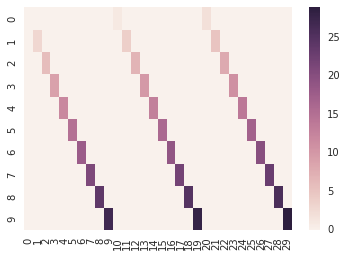

In [4]:
sns.heatmap(explode_stack(X))

In [5]:
X = X.flatten()

In [6]:
X = X.reshape(-1,1)

In [7]:
from scipy import stats

In [8]:
test = [np.arange(0,4).reshape(2,2) for _ in range(5)]

In [9]:
import scipy.linalg as la
scla = la

In [10]:
la.block_diag(*test)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 3]])

In [11]:
def sampling_loop(state):
    all_j(state)
    part_loop(state)
def part_loop(state):
    mu_beta(state)
    tau(state)
    zeta(state)
    gamma(state)

In [12]:
def mu_beta(state):
    st = state
    
    Sni = st.XtX / st.Tau2 + st.mu_cov0i
    Sn = np.linalg.inv(Sni)
    Mn = (st.X.T.dot(st.Y - st.ZGammas -  st.XcZetas)) / st.Tau2 
    Mn += (st.mu_cov0i.dot(st.mu_mean0))
    st.Mus = chol_mvn(Sn.dot(Mn), Sn)
    st.XMus = st.X.dot(st.Mus)
    return st.Mus

def tau(state):
    st = state
    st.eta = st.Y - st.XMus - st.XcZetas - st.ZGammas
    bn = st.eta.T.dot(st.eta) / 2 + st.tau_b0
    st.Tau2 = stats.invgamma.rvs(st.tau_an, scale=bn)
    return st.Tau2

def zeta(state):
    st = state
    zn = st.Xc.T.dot(st.Y - st.ZGammas - st.XMus) / st.Tau2
    Sigma_zni = st.XctXc / st.Tau2 + st.Hi
    Sigma_zn = np.linalg.inv(Sigma_zni)
    st.Zetas = chol_mvn(Sigma_zn.dot(zn), Sigma_zn)
    st.XcZetas = st.Xc.dot(st.Zetas)
    st.Zeta_list = np.split(st.Zetas, st.p)
    return st.Zetas

def gamma(state):
    st = state
    eta_muzeta = st.Y - st.XMus - st.XcZetas
    gn = st.Z.T.dot(eta_muzeta) / st.Tau2 
    gn += st.gammas_cov0i.dot(st.gammas_mean0)
    
    Sgni = st.ZtZ / st.Tau2 - st.gammas_cov0i
    Sgn = np.linalg.inv(Sgni)
    st.Gammas = chol_mvn(Sgn.dot(gn), Sgn)
    st.ZGammas = st.Z.dot(st.Gammas)
    
    return st.Gammas
                           
def all_j(state):
    st = state
    for j in range(len(st.Phi_list)):
        new_phi_j = phi_j(st, j)
        st.Phi_list[j] = new_phi_j
        st.H_list[j] = st.correlation_function(new_phi_j, st.pwds)
        st.Hi_list[j] = np.linalg.inv(st.H_list[j])
        new_sigma_j = sigma_j(st, j)
        st.Sigma2_list[j] = new_sigma_j
    st.H = scla.block_diag(*[Hj * Sigma2j for Hj, Sigma2j in 
                             zip(st.H_list, st.Sigma2_list)])
    st.Hi = scla.block_diag(*[Hji/Sigma2j for Hji, Sigma2j in 
                              zip(st.Hi_list, st.Sigma2_list)])
    return st.Phi_list

def phi_j(state, idx):
    state.j = idx
    st = state
    global_cfgs = state.configs
    this_cfg = global_cfgs.Phi[idx]
    current = state.Phi_list[idx]
    
    try:
        proposal = this_cfg.proposal
    except KeyError:
        proposal = stats.normal
        this_cfg.proposal = proposal
    
    new_val, accepted = metropolis(state, current, proposal, 
                                   logp_phi_j, this_cfg.jump)
    if accepted:
        this_cfg.accepted += 1
    else:
        this_cfg.rejected += 1
    if global_cfgs.tuning:
        acc = this_cfg.accepted
        rej = this_cfg.rejected
        ar = acc / (acc + rej)
        if ar < this_cfg.ar_low:
            this_cfg.jump *= this_cfg.adapt_step
        elif ar > this_cfg.ar_hi:
            this_cfg.jump /= this_cfg.adapt_step
        if acc + rej > this_cfg.max_tuning:
            this_cfg.tuning = False
    return new_val

def logp_phi_j(state, val, j=None):
    if j is None:
        idx = state.j
    else:
        idx = j
    if val < 0:
        return -np.inf
    st = state
    Hj = state.correlation_function(val, state.pwds)
    Hji = np.linalg.inv(Hj)
    Zeta_j = st.Zeta_list[idx]
    Sigma2_j = st.Sigma2_list[idx]
    Phi_j = st.Phi_list[idx]
    c0_j = st.c0_list[idx]
    d0_j = st.d0_list[idx]
    
    logdet = -.5*np.multiply(*np.linalg.slogdet(Hj))
    varterm = -(st.n / 2) * np.log(Sigma2_j)
    phiterm = (c0_j - 1) * np.log(Phi_j)
    norm_kern = (-1/(2*Sigma2_j) 
                 * np.linalg.multi_dot((Zeta_j.T, Hji, Zeta_j)) )
    gamma_kern = - Phi_j * d0_j
    return logdet + varterm + norm_kern + gamma_kern

def sigma_j(state, idx):
    st = state
    idx = st.j
    Hj = st.H_list[idx]
    Hji = st.Hi_list[idx] #could we get this out of Zeta's Hi?
    Zeta_j = st.Zeta_list[idx]
    Sigma2_j = st.Sigma2_list[idx]
    Phi_j = st.Phi_list[idx]
    a0_j = st.a0_list[idx]
    b0_j = st.b0_list[idx]
    
    bjn = Zeta_j.T.dot(Hji).dot(Zeta_j) / 2 + b0_j
    new_sigma = stats.invgamma.rvs(st.an_list[idx], scale=bjn)
    return new_sigma  

In [38]:
from hlm.hierarchical.svcp import SVCP
from hlm.utils import baltim, chol_mvn
from hlm.abstracts import Hashmap
from hlm.steps import metropolis
from scipy.spatial import distance as dist
model = SVCP(**baltim(), n_samples=0)
state = model.state

In [92]:
def convert_svcp_to_mvsvcp(state, phi_startvals=[5,5,5]):
    st = Hashmap(**{k:copy.deepcopy(v) for k,v in state.items()})

    ## PARAMETER SETUP

    state.Tau2 = 2
    state.Zetas = np.zeros((st.n*st.p, 1))
    state.Mus = np.zeros((st.p, 1))
    state.Phi_list = phi_startvals
    state.Sigma2_list = [1]*st.p
    
    
    state.H_list = [state.correlation_function(phi, state.pwds) 
                    for phi in state.Phi_list]
    state.Hi_list = [np.linalg.inv(Hj) for Hj in state.H_list]
    state.Zeta_list = [np.zeros((st.n,1))]*st.p


    ## HYPERPRIOR SETUP
    state.a0_list = [2]*st.p
    state.b0_list = [2]*st.p
    state.c0_list = [1]*st.p
    state.d0_list = [1.5]*st.p

    state.an_list = [state.n/2 + a0 for a0 in state.a0_list]

    state.tau_b0 = 2
    state.tau_an = state.n/2 + 2

    state.mu_cov0i = np.eye(st.p)
    state.mu_mean0 = np.zeros((st.p,1))

    ## DATA SETUP
    state.X = state.Xs
    state.XtX = state.X.T.dot(state.X)
    state.Xc = explode_stack(state.Xs)
    state.XctXc = state.Xc.T.dot(state.Xc)
    state.XcZetas = state.Xc.dot(state.Zetas)

    state.H = scla.block_diag(*state.H_list)
    state.Hi = scla.block_diag(*state.Hi_list)

    ## MCMC Configs

    state.configs = Hashmap(Phi=[Hashmap(proposal=stats.norm, 
                                         ar_low=.4, ar_hi=.6,
                                         adapt_step=1.01, jump=.5, 
                                         accepted=0, rejected=0,
                                         tuning=False, max_adapt=0)
                                 for _ in range(len(state.Phi_list))],
                           tuning=False)
    return state

In [93]:
data, df = baltim(df=True)

In [94]:
df.head()

,STATION,PRICE,NROOM,DWELL,NBATH,PATIO,FIREPL,AC,BMENT,NSTOR,GAR,AGE,CITCOU,LOTSZ,SQFT,X,Y,geometry
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,"(907.0, 534.0)"
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,"(922.0, 574.0)"
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,"(920.0, 581.0)"
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,"(923.0, 578.0)"
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,"(918.0, 574.0)"


In [95]:
Z = df[['AGE', 'AC']].values
state.Z = Z
state.ZtZ = Z.T.dot(Z)
state.ZGammas = np.zeros((state.n, 1))
state.gammas_cov0i = np.eye(2)
state.gammas_mean0 = np.zeros((2,1))

In [96]:
def track_phis(state, n=500):
    np.random.seed(state.seed)
    phis = []
    gammas = []
    for _ in range(n):
        sampling_loop(state)
        phis.append(copy.deepcopy(state.Phi_list))
        gammas.append(copy.deepcopy(state.Gammas))
    return state, phis, gammas

In [97]:
a,b,c = [convert_svcp_to_mvsvcp(state, phi_startvals=[k]*3) for k in [30,50,75]]

In [98]:
a.seed = 111213
b.seed = 12345
c.seed = 9913

In [99]:
import multiprocessing as mp

In [100]:
P = mp.Pool(3)

In [101]:
outs = P.map(track_phis, [a,b,c])

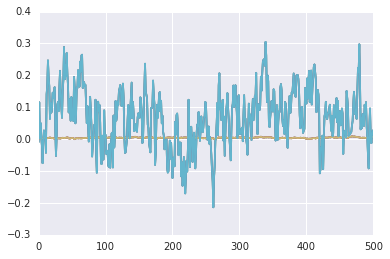

In [102]:
for out in outs:
    plt.plot(np.squeeze(out[-1]))

In [107]:
id(outs[0][-1][0])

139832195731584

In [108]:
id(outs[1][-1][0])

139832195872048

In [110]:
np.allclose(np.asarray(outs[1][-1]), np.asarray(outs[2][-1]))

True

In [23]:
new_model = SVCP(**baltim(), n_jobs=0, n_samples=0, phi_jump = .5)
new_model.sample(1000, n_jobs=3)

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


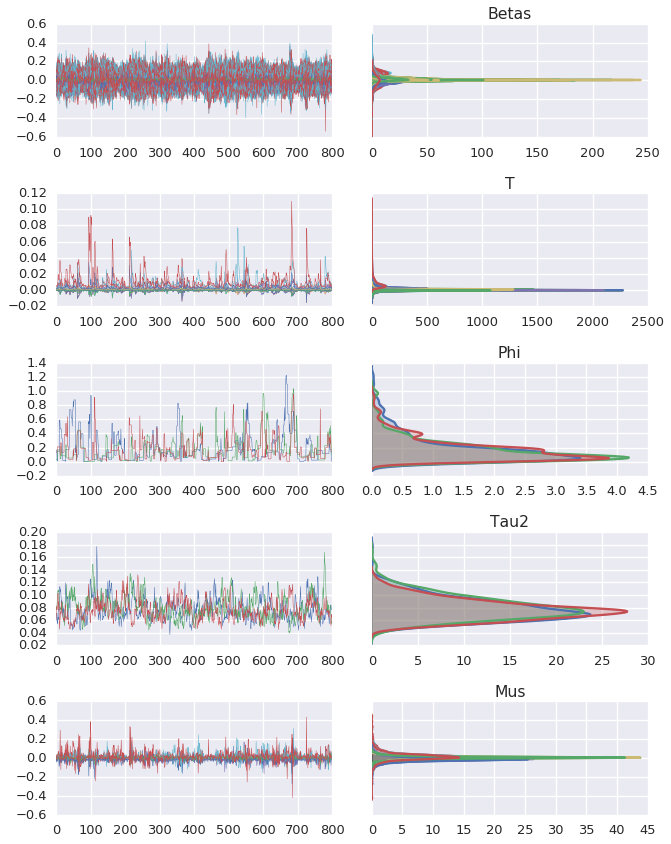

In [25]:
new_model.trace.plot(burn=200)
plt.tight_layout()
plt.show()

In [27]:
from hlm.plotting import svcp as svcplots

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


ZeroDivisionError: 0.0 cannot be raised to a negative power

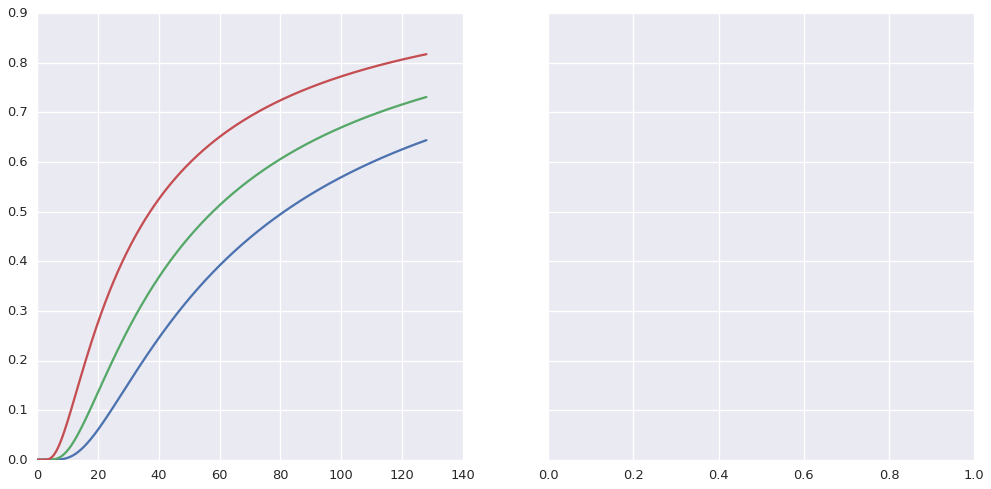

In [31]:
svcplots.corrplot(model)